# Voice Identification Experiment 1

This is the ipynb file for the Digital Signal Processing Experiment.

## Data Preprocessing 

I choose to use the simple endpoint detection to simplify the classification process. To be more specific, I choose to ignore all the noize data whose absolute value is lower than 0.05.

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:13: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
  del sys.path[0]
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


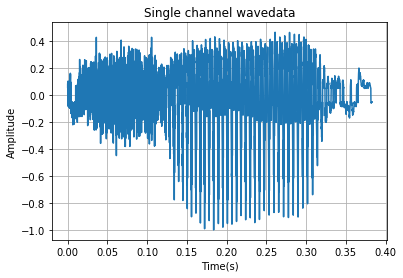

In [2]:
import wave
import matplotlib.pyplot as plt
import numpy as np
import os
 
#filepath = "" #添加路径
filename = 'ryan71.wav'
#filename= os.listdir(filepath) #得到文件夹下的所有文件名称 
f = wave.open(filename,'rb')
params = f.getparams()
nchannels, sampwidth, framerate, nframes = params[:4]
strData = f.readframes(nframes)#读取音频，字符串格式
waveData = np.fromstring(strData,dtype=np.int16)#将字符串转化为int
waveData = waveData*1.0/(max(abs(waveData)))#wave幅值归一化
Data = []
j = 0
for i in range(len(waveData)):
    if abs(waveData[i]) > 0.05:
        Data.append(waveData[i])
        j+=1
    
# plot the wave
time = np.arange(0,j)*(1.0 / framerate)
plt.plot(time,Data)
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.title("Single channel wavedata")
plt.grid('on')#标尺，on：有，off:无。

Firstly we try to preprocess the wavedata using multiple method.

## Enframe, Energy and ZCR

In this code, I use only 2 wav file to test the program which contains the voice information of zero and seven. I used function using double gate algorithms to detect the endpoints of voice and counting the Energy and ZCR to find different features of voice information. The figures of different features are shown below. 

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:29: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


(1264, 1)


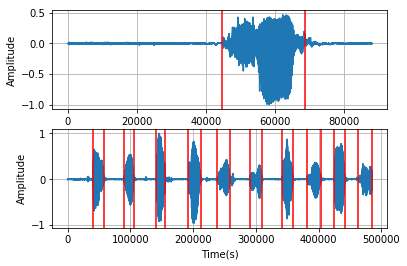

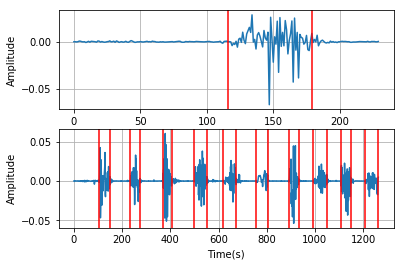

In [4]:
import numpy as np
import wave
import os
import math
import scipy.signal as signal

def Enframe(wavData, frameSize, overlap):#分帧加窗函数
    coeff = 0.97 # 预加重系数
    wlen = len(wavData)
    step = frameSize - overlap
    frameNum = math.ceil(wlen / step)
    frameData = np.zeros((frameSize, frameNum))

    hamwin = np.hamming(frameSize)

    for i in range(frameNum):
        singleFrame = wavData[np.arange(i * step, min(i * step + frameSize, wlen))]
        singleFrame = np.append(singleFrame[0], singleFrame[:-1] - coeff * singleFrame[1:]) # 预加重
        frameData[:len(singleFrame), i] = singleFrame
        frameData[:, i] = hamwin * frameData[:, i] # 加窗，汉明窗，可以改

    return frameData

def wavread(filename):
    f = wave.open(filename,'rb')
    params = f.getparams()
    nchannels, sampwidth, framerate, nframes = params[:4]
    strData = f.readframes(nframes)#读取音频，字符串格式
    waveData = np.fromstring(strData,dtype=np.int16)#将字符串转化为int
    f.close()
    waveData = waveData*1.0/(max(abs(waveData)))#wave幅值归一化
    waveData = np.reshape(waveData,[nframes,nchannels]).T
    return waveData

# 计算每一帧的过零率
def ZCR(frameData):
    frameNum = frameData.shape[1] #获取分帧阵的形态
    frameSize = frameData.shape[0]
    zcr = np.zeros((frameNum, 1)) #设置一个空的矩阵

    for i in range(frameNum):
        singleFrame = frameData[:, i] #分别对每一帧内的数据进行操作
        temp = singleFrame[:frameSize-1] * singleFrame[1:frameSize] #对相邻的位进行相乘操作
        temp = np.sign(temp) #将结果转化为符号
        zcr[i] = np.sum(temp<0) #将负数个数求总数
    return zcr

# 计算每一帧能量
def energy(frameData):
    frameNum = frameData.shape[1]
    ener = np.zeros((frameNum, 1))
    for i in range(frameNum):
        singleframe = frameData[:, i]
        ener[i] = sum(singleframe * singleframe)
    return ener

#新增的利用双门限法的语音端点检测
#增强了识别能力，可以用于多数字的语音信息的断点识别
def VAD_advance(energy):
    MEAN = np.sum(energy)/len(energy)
    High = 0.5*MEAN #语音能量上限
    Low = 0.015*MEAN #能量下限
    Data1 = [] #存放低位能量数据
    Data2 = [] #存放高位能量数据
    Endpoint = [] #存放两个节点
    Flag = 1 #状态位
    Flag2 = 1 #状态位
    for i in range(len(energy)):
        if energy[i] > Low and Flag == 1: #当能量高于低阈值时
            if energy[i-1] < Low: #如果上一帧的能量低于低阈值
                Data1.append(i-1) #将此节点记录下来
                Flag = 0 #状态位置零
        if energy[i] > High and Flag2 == 1: #当能量高于高阈值时
            if energy[i-1] < High: #如果上一帧的能量低于高阈值
                Data2.append(i-1) #将此节点记录下来
                Flag2 = 0 #状态位置零
        if energy[i] < Low and Flag == 0: #当能量低于低阈值时
            if energy[i-1] > Low: #如果上一帧能量高于低阈值
                Data1.append(i) #将此节点记录下来
                Flag = 1 #状态位置一
        if energy[i] < High and Flag2 == 0: #当能量低于高阈值时
            if energy[i-1] > High: #如果上一帧能量高于高阈值
                Data2.append(i) #将此节点记录下来
                Flag2 = 1 #状态位置于一
    i = 0
    j = 0
    while j < len(Data2)/2:#循环遍历数据点，筛选有效的节点
        i = 0
        while i < len(Data1)/2:
            if Data1[2*i]<=Data2[2*j] and Data1[2*i + 1] >= Data2[2*j + 1]:
                Endpoint.append(Data1[2*i])
                Endpoint.append(Data1[2*i+1])
                break
            i += 1
        j += 1
    counter = 2
    temp = 0
    i = 2
    while i < len(Endpoint) - 2: #消除重复点
        if Endpoint[i] != Endpoint[i - 2]:
            Endpoint[counter] = Endpoint[i]
            counter += 1
        i += 1
    endpoint = []
    if len(Endpoint) == 0:
        print("No endpoint detected")
        return 0
    else:
        for i in range(counter):
            endpoint.append(Endpoint[i])
        return endpoint

filename7 = "all.wav"
filename0 = "ryan71.wav"
data0 = wavread(filename0)
data7 = wavread(filename7)
nw = 512
inc = 128
winfunc = signal.hamming(nw)
Frame0 = Enframe(data0[0], nw, inc) 
Frame7 = Enframe(data7[0], nw, inc)
Energy0 = energy(Frame0)
zcr0 = ZCR(Frame0)
Energy7 = energy(Frame7)
zcr7 = ZCR(Frame7)
print(np.shape(Energy7))
time = np.arange(0,nframes)*(1.0 / framerate)
endpoint = VAD_advance(Energy0)
endpoint2 = VAD_advance(Energy7)
plt.figure(1)
plt.subplot(211)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(data0[0])
plt.axvline(endpoint[0]*(512-128), color = 'r')
plt.axvline(endpoint[1]*(512-128), color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.subplot(212)
plt.plot(data7[0])
for i in range(len(endpoint2)):
    plt.axvline(endpoint2[i]*(512-128), color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.grid('on')#标尺，on：有，off:无。
plt.figure(2)
plt.subplot(211)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(Frame0[0])
plt.axvline(endpoint[0], color = 'r')
plt.axvline(endpoint[1], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.subplot(212)
plt.plot(Frame7[0])
for i in range(len(endpoint2)):
    plt.axvline(endpoint2[i], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude")
plt.grid('on')#标尺，on：有，off:无。


/usr/local/lib/python3.5/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


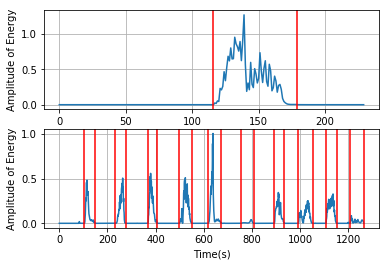

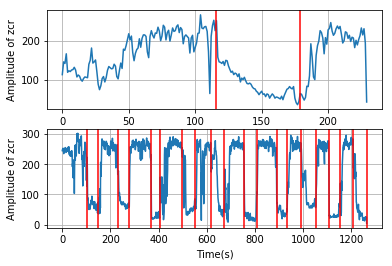

In [9]:
plt.figure(3)
plt.subplot(211)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(Energy0)
plt.axvline(endpoint[0], color = 'r')
plt.axvline(endpoint[1], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of Energy")
plt.subplot(212)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(Energy7)
for i in range(len(endpoint2)):
    plt.axvline(endpoint2[i], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of Energy")
plt.figure(4)
plt.subplot(211)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(zcr0)
plt.axvline(endpoint[0], color = 'r')
plt.axvline(endpoint[1], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of zcr")
plt.grid('on')#标尺，on：有，off:无。
plt.subplot(212)
plt.grid('on')#标尺，on：有，off:无。
plt.plot(zcr7)
for i in range(len(endpoint2)):
    plt.axvline(endpoint2[i], color = 'r')
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of zcr")
plt.grid('on')#标尺，on：有，off:无。

## Useful Functions for Classifier

The svm classifier is applied in the demo below, and several useful functions are used.


### FetchFeatureData(endpoint, feature)
This function can fatch all the active voice information from original data array. Original data and its endpoint point array are needed. 

### ReshapeFeatureData(Data, shape)
This function will reshape the active data to the shape that you prefer. Data refers to the active voice data from function `FatchFeatureData()`, and shape refers to the shape you need, the function will return the reshaped array with shape (number_of_active_data, shape_of_single_data).

All these functions will be useful to different classifier.

### Demo: SVM Classifier
The svm classifier, for example, is utilized in this demo, using all these functions above. And I choose to use zcr feature of file `ryan02.wav`, `all.wav` in `./Notebook`, which has already loaded and preprocessed above.

(1264, 1)
(230, 1)
(11, 10)
1.0


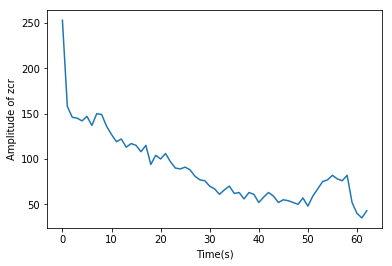

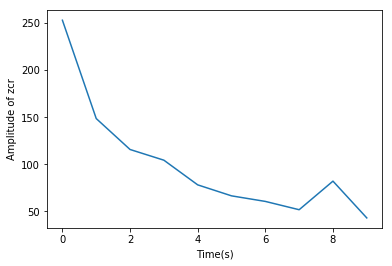

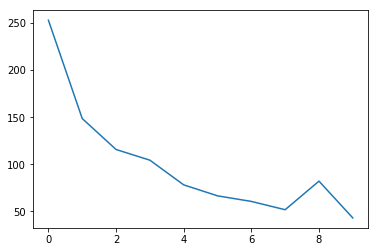

In [14]:
from scipy import interpolate
from sklearn import svm

def FetchFeatureData(endpoints,features):
    '''
    This information is utilized to fatch all the effective information from a voice data array
    :endpoint: the endpoint array of a certain voice data array
    :data: the voice feature information array
    '''
    print(features.shape)
    feature_list = []
    segment_num = int(len(endpoints) / 2)
    for i in range(segment_num):
        start, end = endpoints[2 * i], endpoints[2 * i + 1]
        feature_list.append(features[start: end])
    return feature_list

def ReshapeFeatureDataSet(data, shape):
    '''
    This function is utilized for reshaping the information of data to the shape that you prefer.
    Cubic spline interpolate is utilized in reshaping the array.
    '''
    data_set = []
    for i in range(len(data)):
        new_shape = np.linspace(0, len(data[i]), shape)
        Data = np.reshape(data[i], len(data[i]))
        x = np.linspace(0, len(data[i]), len(data[i]))
        f = interpolate.interp1d(x, Data, kind='cubic')
        data_set.append(f(new_shape))
    return data_set

'''
svm demo
the svm function is import from sklearn.
'''
Data1 = FetchFeatureData(endpoint2,zcr7)  # fatch zcr data
Data1 = ReshapeFeatureDataSet(Data1,10)  # reshape data
Data2 = FetchFeatureData(endpoint,zcr0)
plt.figure(1)
plt.plot(Data2[0])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of zcr")
Data2 = ReshapeFeatureDataSet(Data2,10)
DataSet = np.concatenate((Data1,Data2),axis = 0)  # concatenate two data arrays
print(np.shape(DataSet))
y = [0,1,2,3,4,5,6,7,8,9,7]  # classification result of DataSet
plt.figure(2)
plt.plot(Data2[0])
plt.xlabel("Time(s)")
plt.ylabel("Amplitude of zcr")
plt.figure(3)
plt.plot(DataSet[10])
clt = svm.SVC(C=0.8, kernel='rbf', gamma=20, decision_function_shape='ovr')
clt.fit(DataSet,y)  # svm classification
print(clt.score(DataSet,y))  # svm score